In [1]:
import warnings
warnings.simplefilter("ignore")

import sympy as sp
import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from numba import jit, prange
from tqdm import tqdm

import grad_log_det as log_det
import gen_mat as gen
from mva_test import test_points_gen

from scipy.stats import norm, uniform
#import math
#from scipy.special import comb

#import arviz as az
#import pymc3 as pm
#print('Runing on PyMC3 v{}'.format(pm.__version__))

from numba import jit

%matplotlib inline

In [2]:
def func_t2(x_in):
    #print(x_in.shape)
    return np.array([np.sin(x)*np.cos(y)*norm.pdf(x)*norm.pdf(y) for (x,y) in x_in])**2

def func_t10(x_in):
    #print(x_in.shape)
    return np.array([  np.prod((np.sin(x)**2)*norm.pdf(x)) for x in x_in])


def pdf_sample(func, dim, coeff, N_tot=1000, distr=norm, check_good=True):
    # use normal distrinution
    #for i in range(N):
    res = np.empty((N_tot, dim))
    #N = 100
    #N = int(N_tot/4)
    N = N_tot*4
    i = 0
    while i < N_tot:
        x = distr.rvs(size=N*dim).reshape((N, dim))
        u = uniform.rvs(size=N)
        val = distr.pdf(x).prod(axis=1)*coeff
        func_vals = func(x)
        good = val*u < func_vals
        if check_good:
            if (func_vals > val).any():
                print('bad choice of coeff')

        l_good = np.sum(good)
        if l_good <= N_tot - i:
            res[i:i+l_good] = x[good]
            i += l_good
        else:
            res[i:] = x[good][:N_tot - i]
            i = N_tot
            
        print(i)


    return res
       
@jit    
def dependent_normal(x, B = np.array([[1,0.7],[0.7, 1]])):
    return np.exp( - x@B@x/(2*0.03) )
    #print(',')
    #return np.exp( - x@x/(2*.03) )
    
    
@jit    
def MCMC_sample(func, dim, burn=10, return_p=False):
    
    xi = uniform.rvs(loc=-1, scale=2, size=dim)
    
    xip_a = uniform.rvs(loc=-1, scale=2, size=burn*dim).reshape((burn, dim))
    u_a = uniform.rvs(size=burn)
    
    skoks = 0
    for xip, u in zip(xip_a, u_a):
        #rho = np.prod(distr.pdf(xip_a))*func(xip) /\
        #        (np.prod(distr.pdf(xi))*func(xi))
        rho = func(xip) / func(xi)
        if u < rho:
            xi = xip
            skoks += 1
        
    if return_p:
        return skoks
    else:
        return xi
            


def make_B(dim, p):
    P = gen.binom_sh(p=p, l=dim)
    #f = gen.GenFunc([0]*P, dim, poly=gen.legendre, ret_sum=False)
    f = gen.GenFunc([0]*P, dim, poly=gen.legendre, ret_sum=False)
    
    # @jit kernel dies ccyka
    def B(x):
        y = f(*x)
        return y@y
    
    return B


# for jit starts
MCMC_sample(dependent_normal, 2, burn=10);

In [6]:
tol = 1e-12

# This is log-det of A.T@A
def D_optimality(A):
    S = LA.svd(A, compute_uv=False)
    S[S < tol] = tol
    ld = 2.0*np.sum(np.log(S))
    return ld

In [7]:
def log_det_update(current_inv, current_det, new_row):
    updated_det = current_det + np.log((1+new_row@current_inv@new_row.T))
    return updated_det
    
def inv_update(current_inv, new_row):
    updated_inv = current_inv - (1/(1+new_row@current_inv@new_row.T))*(current_inv@new_row.T)@new_row@current_inv
    return updated_inv

In [8]:
# This is with fast rank-1 update of determinant and matrix inverse

@jit(parallel=True, nogil = True)
def Algorithm_1_fast(A, N, criterion):
    N_candidate, P = A.shape
    I = []
    J = []
    current_inv = 1
    current_det = 1
    for n in range(N):
        if n < P:
            J.append(n) 
        
        if n >= P:
            current_max = -np.inf
            i_cand = 0
            for i in list(set(range(N_candidate)) - set(I)):
                I.append(i)
                current_d = log_det_update(current_inv, current_det, A[i,:].reshape(1,-1))
                if current_d > current_max:
                    current_max = current_d
                    i_cand = I.pop()
                    continue
                I.pop()
            I.append(i_cand)
            current_inv = inv_update(current_inv, A[i_cand,:].reshape(1,-1))
            current_det = current_max
            continue
            
        
        current_max = -np.inf
        i_cand = 0
        for i in list(set(range(N_candidate)) - set(I)):
            I.append(i)
            current_d = criterion(A[np.ix_(I, J)])      
            if current_d > current_max:
                current_max = current_d
                i_cand = I.pop()
                continue
            I.pop()
        I.append(i_cand)
        
        if n == P-1:
            current_inv = LA.inv(A[np.ix_(I, J)].T@A[np.ix_(I, J)])
            current_det = criterion(A[np.ix_(I, J)])
    return I

In [9]:
# This is slow version WITHOUT rank-1 updates
@jit(parallel=True, nogil = True)
def Algorithm_1(A, N, criterion):
    N_candidate, P = A.shape
    I = []
    J = []
    for n in range(N):
        if n < P:
            J.append(n)
        current_max = -np.inf
        i_cand = 0
        for i in list(set(range(N_candidate)) - set(I)):
            I.append(i)
            current_d = criterion(A[np.ix_(I, J)])
            if current_d > current_max:
                current_max = current_d
                i_cand = I.pop()
                continue
            I.pop()
        I.append(i_cand)
    return I

In [10]:
def GD_points(num_col=50, num_points=54, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre):
    log_det.num_col = num_col
    log_det.dim = dim  
    bnds = (interval,) * (dim*num_points)
    dstrs = ['LHS']
        
    loss_f = lambda x: log_det.loss_func(x, poly=poly, ToGenDiff=False)
    loss_grad = lambda x: log_det.grad(x, poly=poly)
    res = np.inf
    for distrib in dstrs:
        for _ in range(num_tries):
            x_0 = test_points_gen(num_points, dim, interval=interval, distrib=distrib) # starting point of GD
            x_0 = x_0.ravel('F')
            op = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = loss_grad, factr = 10.0, bounds = bnds)
            res_cur = op[1]
            if res_cur < res:
                res = res_cur
                pnts = op[0]
            
    pnts = pnts.reshape(pnts.size//dim, dim, order="F")             
    return pnts

In [11]:
def error(f, f_tilda):
    return LA.norm(f-f_tilda,2)/LA.norm(f,2)

In [12]:
def rhs(A, c, noise=False):
    if noise:
        return A@c + 0.03*abs(A@c)*np.random.randn(A.shape[0],1) 
    return A@c

In [13]:
def lstsq_weighted(A, rhs, w):
    assert A.shape[0] == len(w) == len(rhs), "Dimenstion mismatch: {}, {}, {}".format(A.shape[0], len(w), len(rhs))
    #print("Initilal shape A: {}".format(A.shape))
    #print("Initilal shape rhs: {}".format(rhs.shape))
    A = (A.T*w).T
    rhs = (rhs.T*w).T
    #print("Ending shape A: {}".format(A.shape))
    #print("Ending shape rhs: {}".format(rhs.shape))
    #print("shape w: {}".format(w.shape))
    
    return LA.lstsq(A, rhs, rcond=-1)[0]

def Legendre_wt(x):
    num_pnts, d = x.shape
    ret = np.ones(num_pnts)
    for pnt in range(num_pnts):
        #for i in range(d):
        #    ret[pnt] *= (1.0 - x[pnt, i]**2)**0.25
        ret[pnt] = np.prod((1.0 - x[pnt, :]**2)**0.25)
            
    return ret
        

In [29]:
def experiment_from_paper(p=2, d=15, distrib_base='random', range_plot=np.arange(1,11), num_test_pnts = int(1e4)):

    #np.random.seed(42)

    num_tests = 60
    Nc_N_ratio = 4
    #num_tests = 1


    burn = 15

    f1 = make_B(d, p)
    # dim = d
    interval = (-1.,1.)
    P = gen.binom_sh(p=p, l=d)
    N_div_P = range_plot

    c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

    errors = []
    errors_wt = []
    errors_rho = []

    for N in N_div_P:
        N = N*P
        N_c = Nc_N_ratio*N

        errors_maxvol = []
        errors_maxvol_wt = []
        errors_maxvol_rho = []

        for i in tqdm(range(num_tests)):
            pnts_test = test_points_gen(num_test_pnts, d, interval=interval, distrib='random')
            Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
            rhs_test = rhs(Phi_test, c_true)

            pnts = test_points_gen(N_c, d, interval=interval, distrib=distrib_base)
            Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

            pnts_rho = np.array([MCMC_sample(f1, d, burn=burn) for _ in range(N_c)])
            Phi_c_rho = gen.GenMat(P, pnts_rho, poly=gen.legendre, ToGenDiff=False)

    #         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)

            rows_maxvol, _ = rect_maxvol(Phi_c, tol = 1.00, minK = N, maxK = N)
            good_pnts = Phi_c[rows_maxvol]
            f_train_maxvol = rhs(good_pnts, c_true, noise=True)
            c_approx_maxvol = LA.lstsq(good_pnts, f_train_maxvol, rcond=-1)[0]

            rows_maxvol_rho, _ = rect_maxvol(Phi_c_rho, tol = 1.01, minK = N, maxK = N)
            good_pnts_rho = Phi_c_rho[rows_maxvol_rho]
            f_train_maxvol_rho = rhs(good_pnts_rho, c_true, noise=True)
            c_approx_maxvol_rho = LA.lstsq(good_pnts_rho, f_train_maxvol_rho, rcond=-1)[0]


            #print(c_approx_maxvol.shape)

            #wt = Legendre_wt(pnts[rows_maxvol])
            wt = np.sqrt(P)*np.array([f1(x)**(-0.5) for x in pnts_rho[rows_maxvol_rho]])

            c_approx_maxvol_wt = lstsq_weighted(good_pnts_rho, f_train_maxvol_rho, wt)
            #print(c_approx_maxvol_wt.shape)


            errors_maxvol.append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
            errors_maxvol_wt.append(error(rhs_test, Phi_test@c_approx_maxvol_wt) <= 0.02)
            errors_maxvol_rho.append(error(rhs_test, Phi_test@c_approx_maxvol_rho) <= 0.02)

        errors.append(sum(errors_maxvol)/len(errors_maxvol))
        errors_wt.append(sum(errors_maxvol_wt)/len(errors_maxvol_wt))
        errors_rho.append(sum(errors_maxvol_rho)/len(errors_maxvol_rho))


    # use np.loadtxt to load
    np.savetxt("errors_{}_{}.txt".format(p, d), [errors, errors_wt, errors_rho])        
        
    plt.figure(figsize=(10,8), dpi=100)

    plt.plot(N_div_P, errors, 'darkorange', label='D-opt')
    plt.plot(N_div_P, errors_wt, 'darkred',label='D-coh-opt + wt')
    plt.plot(N_div_P, errors_rho, label='D-coh-opt')
    plt.xlabel('N/P')
    plt.ylabel('Probability of success')
    plt.xlim(1,10)
    plt.ylim(0,1.005)
    plt.legend()
    plt.show()    

100%|██████████| 60/60 [05:22<00:00,  5.37s/it]


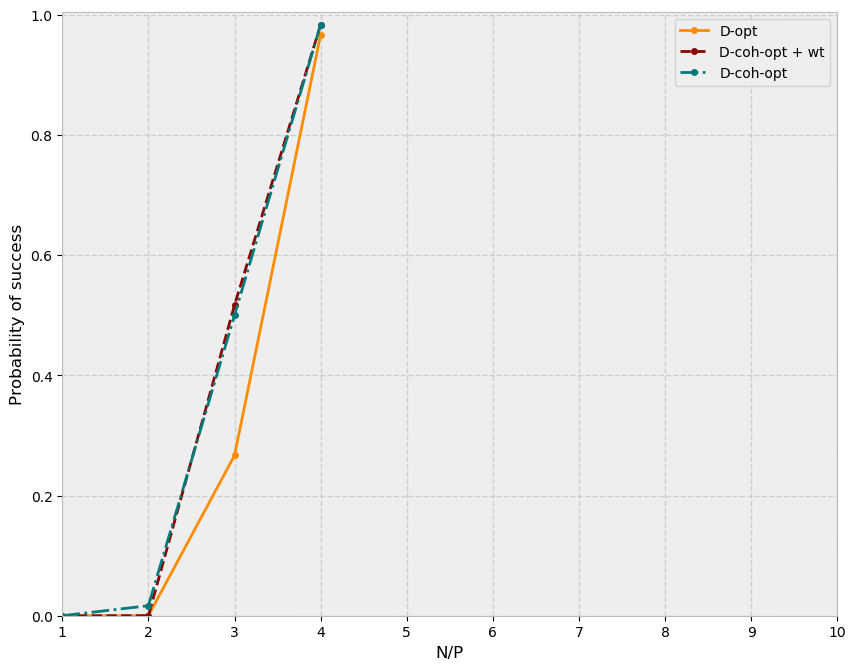

In [18]:
experiment_from_paper(p=2, d=15, distrib_base='random', range_plot=np.arange(1,5), num_test_pnts = int(1e5))

100%|██████████| 60/60 [03:28<00:00,  3.48s/it]


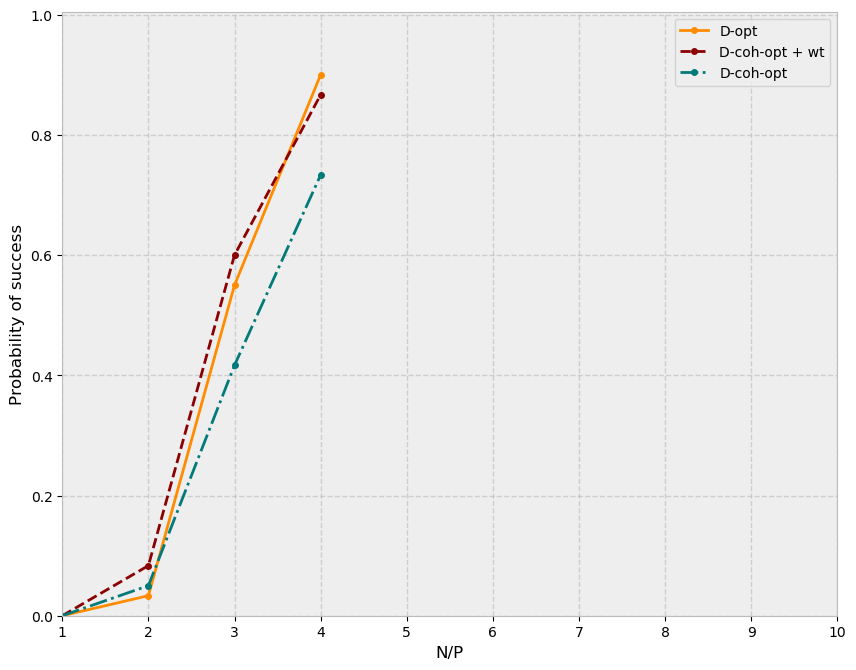

In [30]:
experiment_from_paper(p=4, d=4, distrib_base='random', range_plot=np.arange(1,5), num_test_pnts = int(1e5))

100%|██████████| 60/60 [03:38<00:00,  3.64s/it]


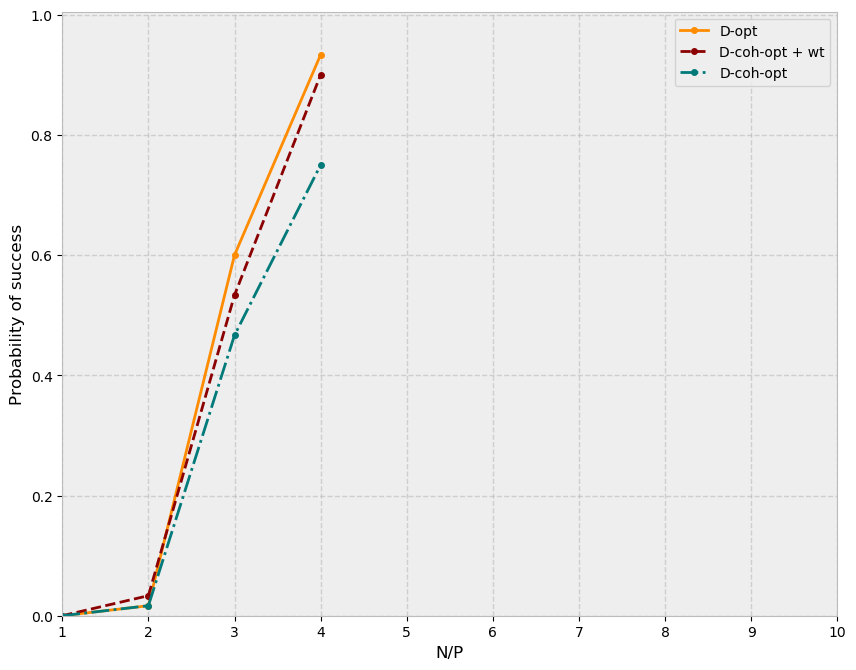

In [24]:
experiment_from_paper(p=4, d=4, distrib_base='random', range_plot=np.arange(1,5), num_test_pnts = int(1e5))

100%|██████████| 60/60 [7:25:16<00:00, 445.27s/it]  


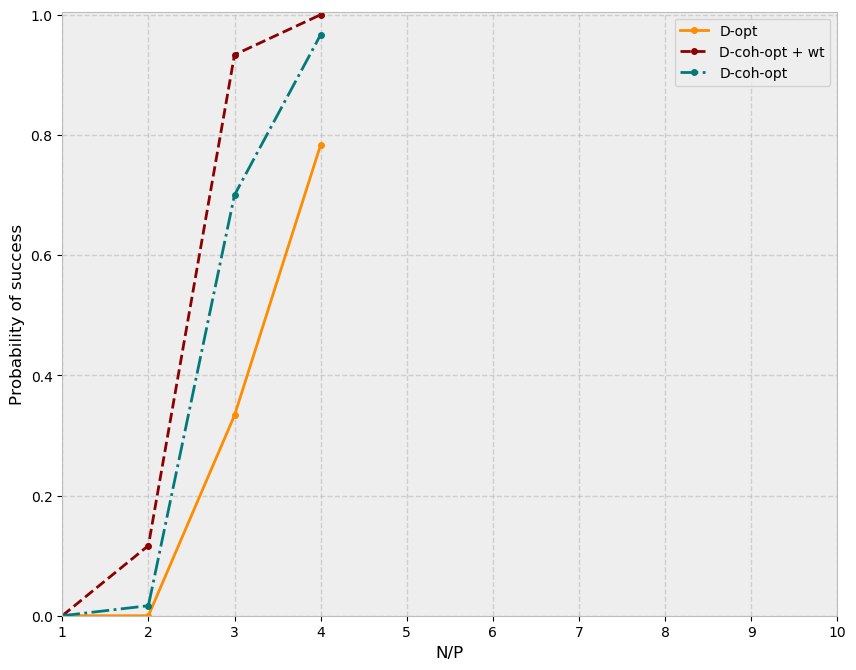

In [26]:
experiment_from_paper(p=15, d=2, distrib_base='random', range_plot=np.arange(1,5), num_test_pnts = int(1e5))

100%|██████████| 60/60 [04:23<00:00,  4.39s/it]


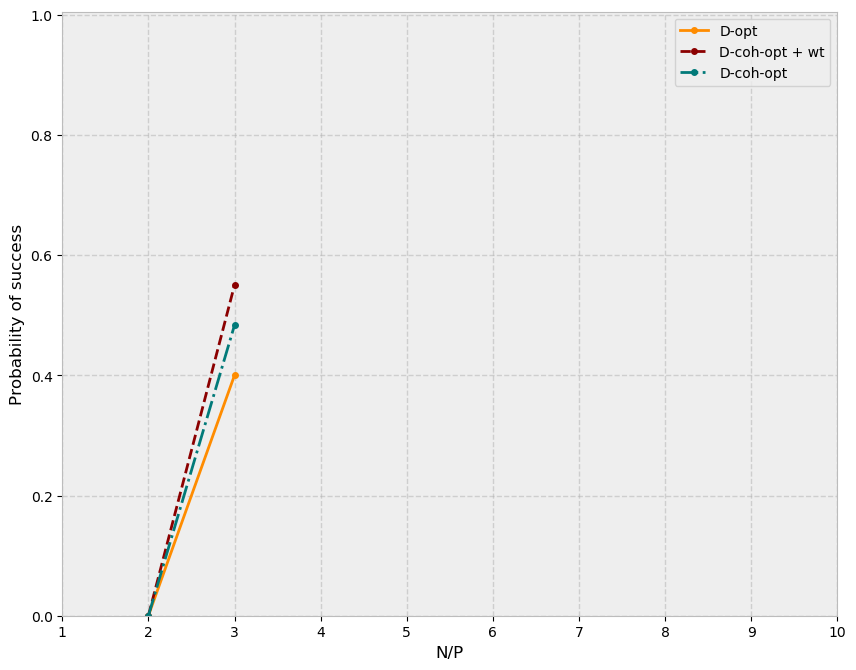

In [27]:
experiment_from_paper(p=2, d=15, distrib_base='random', range_plot=np.arange(2,4), num_test_pnts = int(1e5))

100%|██████████| 60/60 [04:26<00:00,  4.44s/it]


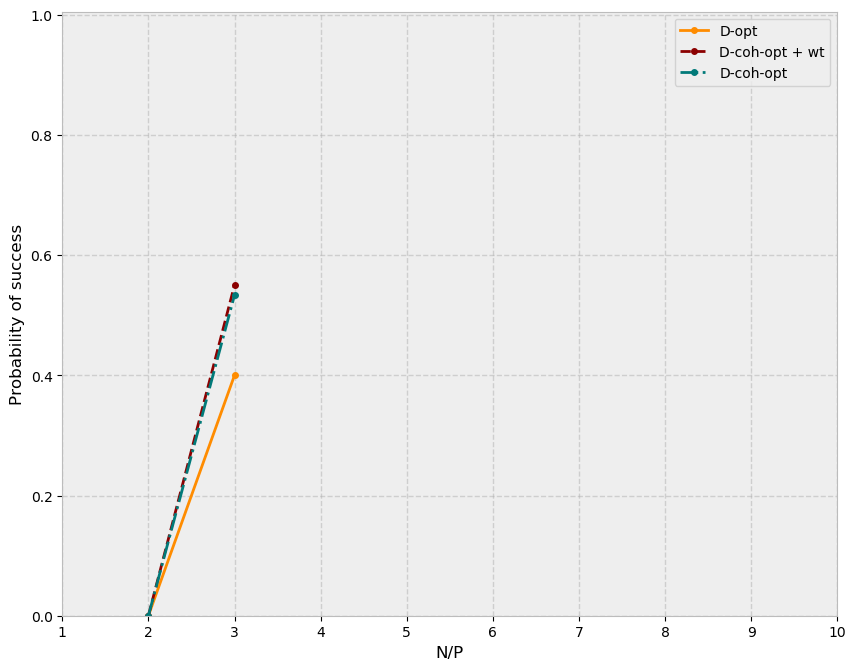

In [28]:
experiment_from_paper(p=2, d=15, distrib_base='random', range_plot=np.arange(2,4), num_test_pnts = int(1e5))

100%|██████████| 60/60 [04:27<00:00,  4.47s/it]


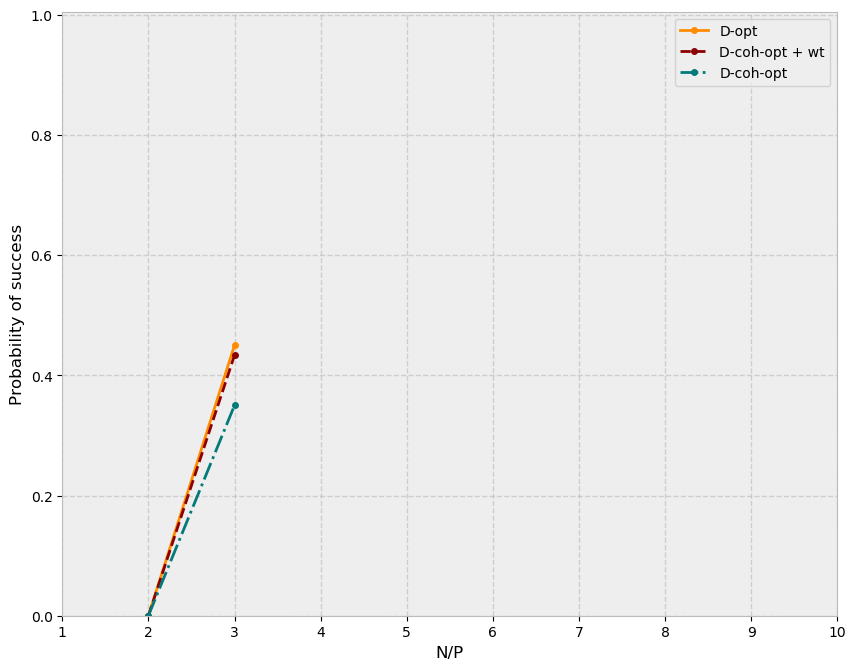

In [31]:
experiment_from_paper(p=2, d=15, distrib_base='random', range_plot=np.arange(2,4), num_test_pnts = int(1e5))

# Some tests on MCMC

In [3]:
%%time
p = 4
dim = 4
N = 1
burn = 10000


f1 = make_B(dim, p)
trace = np.array([MCMC_sample(f1, dim, burn=burn, return_p=True) for _ in range(N)])
float(trace[0])/burn

CPU times: user 10.4 s, sys: 47.2 ms, total: 10.4 s
Wall time: 10.6 s


0.713

In [23]:
%%time
## need to count
## LONG TIME
p = 2
dim = 15
N = 1000
burn = 1000

f1 = make_B(dim, p)
trace = np.array([MCMC_sample(f1, dim, burn=burn) for _ in range(N)])


plt.figure(figsize=(10, 10))
plt.scatter(trace[:, 0], trace[:, 1])

KeyboardInterrupt: 

CPU times: user 5.2 s, sys: 34.6 ms, total: 5.23 s
Wall time: 5.29 s


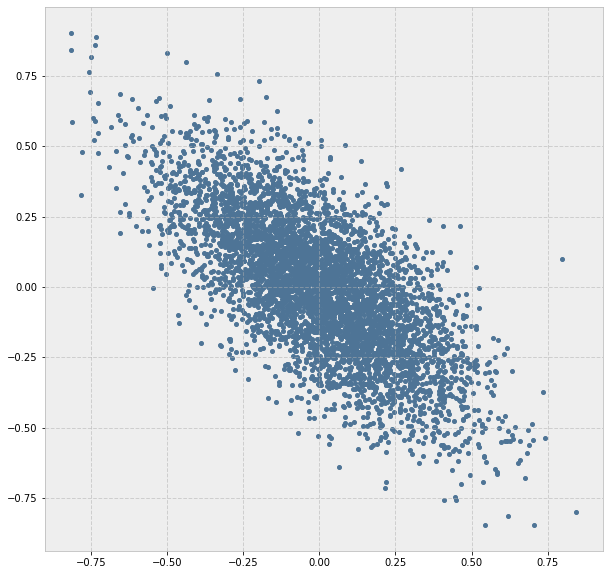

In [4]:
%%time
# Just test

trace = np.array([MCMC_sample(dependent_normal, 2, burn=1000) for _ in range(5000)])

plt.figure(figsize=(10, 10))
plt.scatter(trace[:, 0], trace[:, 1])

CPU times: user 2min 24s, sys: 282 ms, total: 2min 24s
Wall time: 2min 26s


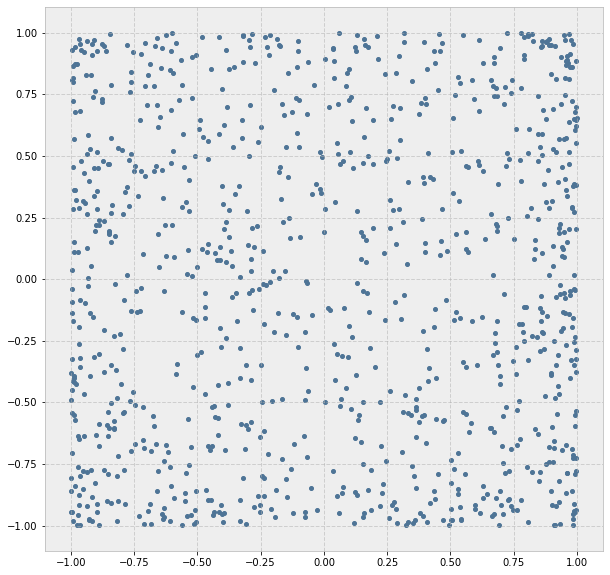

In [5]:
%%time
p = 15
dim = 2
N = 1000
burn = 10


f1 = make_B(dim, p)
trace = np.array([MCMC_sample(f1, dim, burn=burn) for _ in range(N)])

plt.figure(figsize=(10, 10))
plt.scatter(trace[:, 0], trace[:, 1])

In [ ]:
np.random.seed(42)

p = 2
d = 15
num_tests = 60
#del dim

Nc_N_ratio = 4
#num_tests = 1
num_test_pnts = int(1e4)


burn = 10

P = comb(p, d, exact=True)
f1 = make_B(d, p)
# dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = []
errors_wt = []
errors_rho = []

for N in N_div_P:
    N = N*P
    N_c = Nc_N_ratio*N
    
    errors_maxvol = []
    errors_maxvol_wt = []
    errors_maxvol_rho = []

    for i in tqdm(range(num_tests)):
        pnts_test = test_points_gen(num_test_pnts, d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
        Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
        
        pnts_rho = np.array([MCMC_sample(f1, d, burn=burn) for _ in range(N_c)])
        Phi_c_rho = gen.GenMat(P, pnts_rho, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
        rows_maxvol, _ = rect_maxvol(Phi_c, tol = 1.01, minK = N, maxK = N)
        good_pnts_rho = Phi_c[rows_maxvol]
        f_train_maxvol = rhs(good_pnts_rho, c_true, noise=True)
        c_approx_maxvol = LA.lstsq(good_pnts_rho, f_train_maxvol, rcond=-1)[0]
        
        rows_maxvol_rho, _ = rect_maxvol(Phi_c_rho, tol = 1.01, minK = N, maxK = N)
        good_pnts_rho = Phi_c_rho[rows_maxvol_rho]
        f_train_maxvol_rho = rhs(good_pnts_rho, c_true, noise=True)
        c_approx_maxvol_rho = LA.lstsq(good_pnts_rho, f_train_maxvol_rho, rcond=-1)[0]
        
        
        #print(c_approx_maxvol.shape)
        
        #wt = Legendre_wt(pnts[rows_maxvol])
        wt = np.sqrt(P)*np.array([f1(x)**(-0.5) for x in pnts_rho[rows_maxvol_rho]])
        
        c_approx_maxvol_wt = lstsq_weighted(good_pnts_rho, f_train_maxvol_rho, wt)
        #print(c_approx_maxvol_wt.shape)
        

        errors_maxvol.append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
        errors_maxvol_wt.append(error(rhs_test, Phi_test@c_approx_maxvol_wt) <= 0.02)
        errors_maxvol_rho.append(error(rhs_test, Phi_test@c_approx_maxvol_rho) <= 0.02)
        
    errors.append(sum(errors_maxvol)/len(errors_maxvol))
    errors_wt.append(sum(errors_maxvol_wt)/len(errors_maxvol_wt))
    errors_rho.append(sum(errors_maxvol_rho)/len(errors_maxvol_rho))
    
  

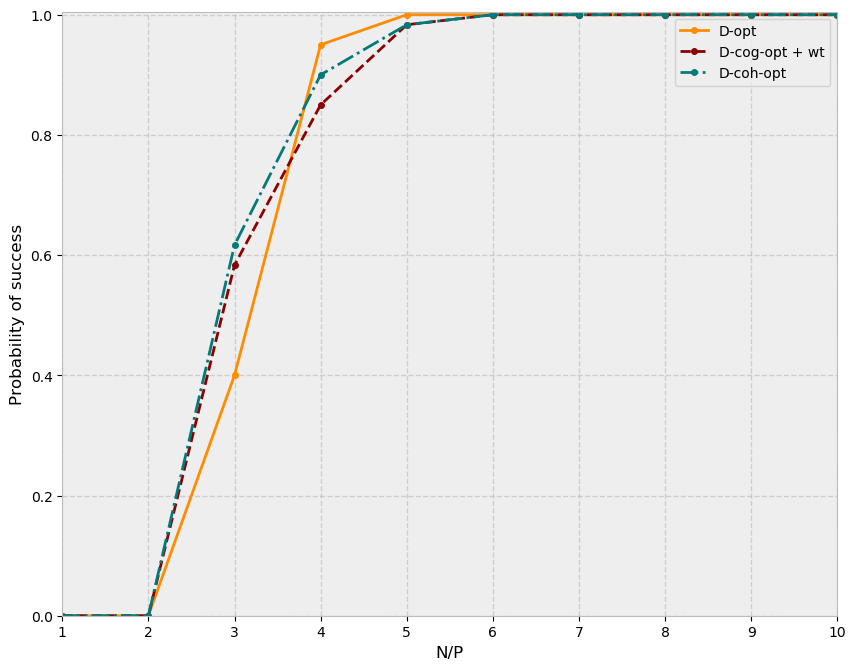

In [24]:
  
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange',  label='D-opt')
plt.plot(N_div_P, errors_wt, 'darkred',  label='D-cog-opt + wt')
plt.plot(N_div_P, errors_rho, label='D-coh-opt')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()    

In [16]:
np.random.seed(33)

Nc_N_ratio = 4


p = 2
d = 2
dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = []
errors_al = []

for N in N_div_P:
    N = N*P
    N_c = Nc_N_ratio*N
    
    errors_maxvol = []
    errors_gd = []
    errors_algo = []

    for i in tqdm(range(60)):
        pnts_test = test_points_gen(int(1e4), d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
        Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
        rows_maxvol,_ = rect_maxvol(Phi_c, tol = 1.01, minK = N, maxK = N)
        rows_algo = Algorithm_1_fast(Phi_c, N, D_optimality)

        f_train_maxvol = rhs(Phi_c[rows_maxvol],c_true,noise=True)
#         f_train_gd = rhs(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False),c_true,noise=True)
        f_train_algo = rhs(Phi_c[rows_algo],c_true,noise=True)

        c_approx_maxvol = LA.lstsq(Phi_c[rows_maxvol], f_train_maxvol, rcond=-1)[0]
#         c_approx_gd = LA.lstsq(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False), f_train_gd, rcond=-1)[0]
        c_approx_algo = LA.lstsq(Phi_c[rows_algo], f_train_algo, rcond=-1)[0]
        
        # Uncomment for LHS
#         pnts = test_points_gen(N, d, interval=interval, distrib='LHS')
#         Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
#         f_train_maxvol = rhs(Phi_c,c_true,noise=True)
#         c_approx_maxvol = LA.lstsq(Phi_c, f_train_maxvol, rcond=-1)[0]

        errors_maxvol.append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
#         errors_gd.append(error(rhs_test, Phi_test@c_approx_gd) <= 0.02)
        errors_algo.append(error(rhs_test, Phi_test@c_approx_algo) <= 0.02)
#     print(mean(errors_maxvol), std(errors_maxvol))
    errors.append(sum(errors_maxvol)/len(errors_maxvol))
#     errors_al.append(sum(errors_gd)/len(errors_gd))
    errors_al.append(sum(errors_algo)/len(errors_algo))

100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


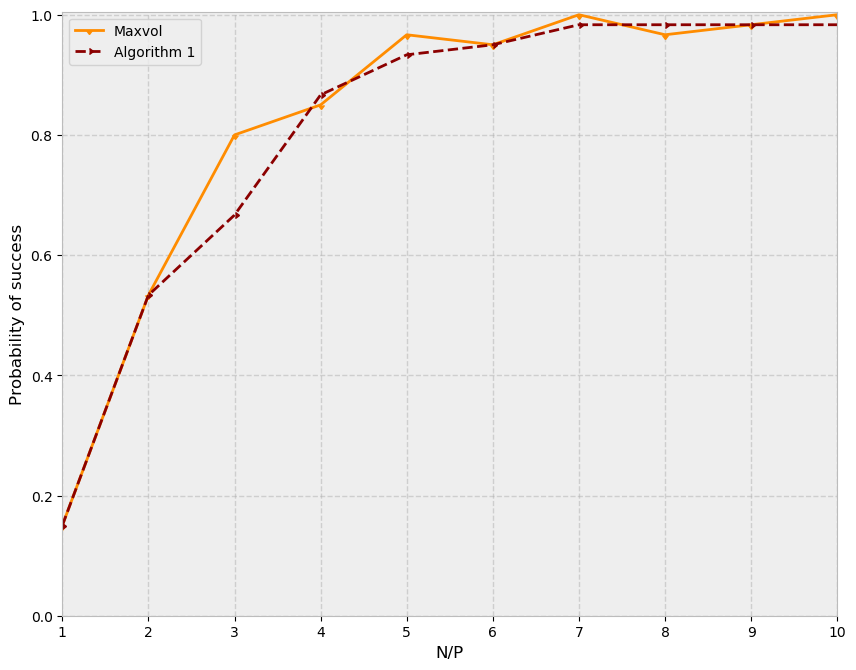

In [17]:
# Nc_N_ratio = 4
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange', marker=11, label='Maxvol')
plt.plot(N_div_P, errors_al, 'darkred', marker=9, label='Algorithm 1')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

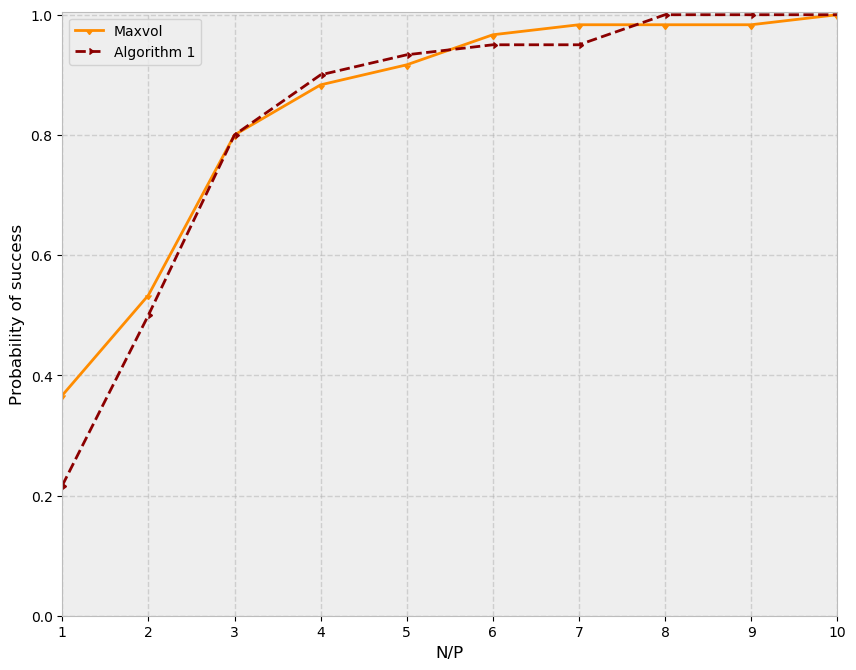

In [15]:
# Nc_N_ratio = 1000
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange', marker=11, label='Maxvol')
plt.plot(N_div_P, errors_al, 'darkred', marker=9, label='Algorithm 1')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

# Compare only MaxVols

In [23]:
np.random.seed(42)

Nc_N_ratios = [4, 100, 10000]
num_tests = 200

p = 2
d = 2
dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = dict()
for Nc in Nc_N_ratios:
    errors[Nc] = []


for N in N_div_P:
    N = N*P
    #N_c = Nc_N_ratio*N
    
    errors_maxvol = dict()
    for Nc in Nc_N_ratios:
        errors_maxvol[Nc] = []

    for i in tqdm(range(num_tests)):
        pnts_test = test_points_gen(int(1e4), d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        for Nc in Nc_N_ratios:
            N_c = Nc*N
            pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
            Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
            rows_maxvol,_ = rect_maxvol(Phi_c, tol = 1.0, minK = N, maxK = N)
            #rows_algo = Algorithm_1_fast(Phi_c, N, D_optimality)

            f_train_maxvol = rhs(Phi_c[rows_maxvol],c_true,noise=True)
#         f_train_gd = rhs(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False),c_true,noise=True)
            #f_train_algo = rhs(Phi_c[rows_algo],c_true,noise=True)

            c_approx_maxvol = LA.lstsq(Phi_c[rows_maxvol], f_train_maxvol, rcond=-1)[0]
        
#         c_approx_gd = LA.lstsq(gen.GenMat(P, points_GD, poly=gen.legendre, ToGenDiff=False), f_train_gd, rcond=-1)[0]
            #c_approx_algo = LA.lstsq(Phi_c[rows_algo], f_train_algo, rcond=-1)[0]
        
        # Uncomment for LHS
#         pnts = test_points_gen(N, d, interval=interval, distrib='LHS')
#         Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
#         f_train_maxvol = rhs(Phi_c,c_true,noise=True)
#         c_approx_maxvol = LA.lstsq(Phi_c, f_train_maxvol, rcond=-1)[0]

            errors_maxvol[Nc].append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
#         errors_gd.append(error(rhs_test, Phi_test@c_approx_gd) <= 0.02)
            #errors_algo[Nc].append(error(rhs_test, Phi_test@c_approx_algo) <= 0.02)
#     print(mean(errors_maxvol), std(errors_maxvol))
    for Nc in Nc_N_ratios:
        errors[Nc].append(sum(errors_maxvol[Nc])/len(errors_maxvol[Nc]))
#     errors_al.append(sum(errors_gd)/len(errors_gd))
    #errors_al.append(sum(errors_algo)/len(errors_algo))

100%|██████████| 200/200 [13:31<00:00,  4.06s/it]


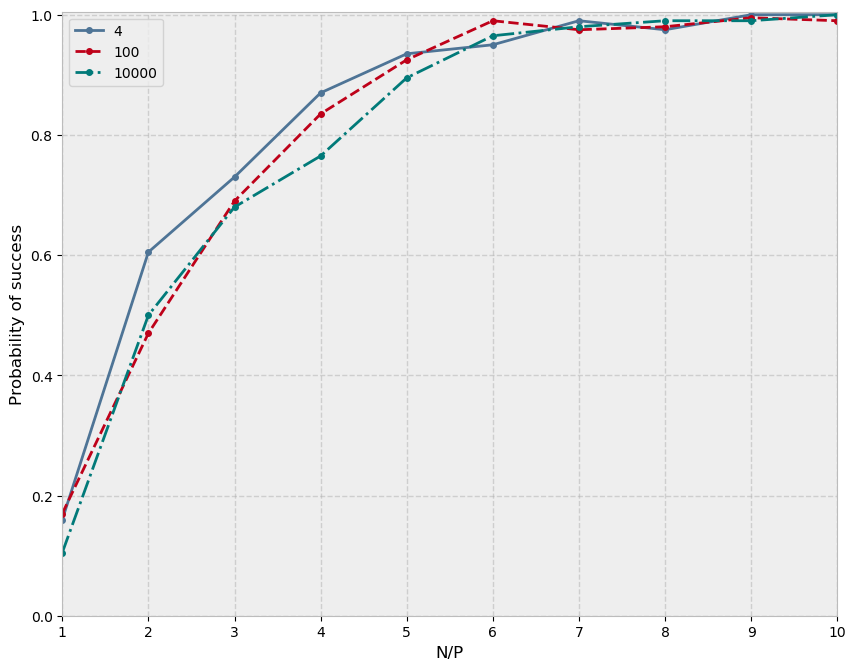

In [25]:
plt.figure(figsize=(10,8), dpi=100)

for Nc in Nc_N_ratios:
    plt.plot(N_div_P, errors[Nc], label=str(Nc))
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

# wighted MaxVol

In [20]:
np.random.seed(33)

Nc_N_ratio = 4
num_tests = 5000
#num_tests = 1
num_test_pnts = int(1e4)


p = 2
d = 2
dim = d
interval = (-1.,1.)
P = gen.binom_sh(p=p,l=d)
N_div_P = np.arange(1,11)

c_true = np.array([np.random.randn() for x in range(P)]).reshape((-1,1))

errors = []
errors_wt = []

for N in N_div_P:
    N = N*P
    N_c = Nc_N_ratio*N
    
    errors_maxvol = []
    errors_maxvol_wt = []

    for i in tqdm(range(num_tests)):
        pnts_test = test_points_gen(num_test_pnts, d, interval=interval, distrib='random')
        Phi_test = gen.GenMat(P, pnts_test, poly=gen.legendre, ToGenDiff=False)
        rhs_test = rhs(Phi_test, c_true)
              
        pnts = test_points_gen(N_c, d, interval=interval, distrib='random')
        Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)

#         points_GD = GD_points(num_col=P, num_points=N, num_tries=1, interval=(-1.0,1.0), poly=gen.legendre)
        
        rows_maxvol,_ = rect_maxvol(Phi_c, tol = 1.01, minK = N, maxK = N)

        f_train_maxvol = rhs(Phi_c[rows_maxvol], c_true, noise=True)

        c_approx_maxvol = LA.lstsq(Phi_c[rows_maxvol], f_train_maxvol, rcond=-1)[0]
        #print(c_approx_maxvol.shape)
        
        wt = Legendre_wt(pnts[rows_maxvol])
        c_approx_maxvol_wt = lstsq_weighted(Phi_c[rows_maxvol], f_train_maxvol, wt)
        #print(c_approx_maxvol_wt.shape)
        
        # Uncomment for LHS
#         pnts = test_points_gen(N, d, interval=interval, distrib='LHS')
#         Phi_c = gen.GenMat(P, pnts, poly=gen.legendre, ToGenDiff=False)
#         f_train_maxvol = rhs(Phi_c,c_true,noise=True)
#         c_approx_maxvol = LA.lstsq(Phi_c, f_train_maxvol, rcond=-1)[0]

        errors_maxvol.append(error(rhs_test, Phi_test@c_approx_maxvol) <= 0.02)
#         errors_gd.append(error(rhs_test, Phi_test@c_approx_gd) <= 0.02)
        errors_maxvol_wt.append(error(rhs_test, Phi_test@c_approx_maxvol_wt) <= 0.02)
#     print(mean(errors_maxvol), std(errors_maxvol))
    errors.append(sum(errors_maxvol)/len(errors_maxvol))
#     errors_al.append(sum(errors_gd)/len(errors_gd))
    errors_wt.append(sum(errors_maxvol_wt)/len(errors_maxvol_wt))

100%|██████████| 5000/5000 [00:24<00:00, 201.22it/s]


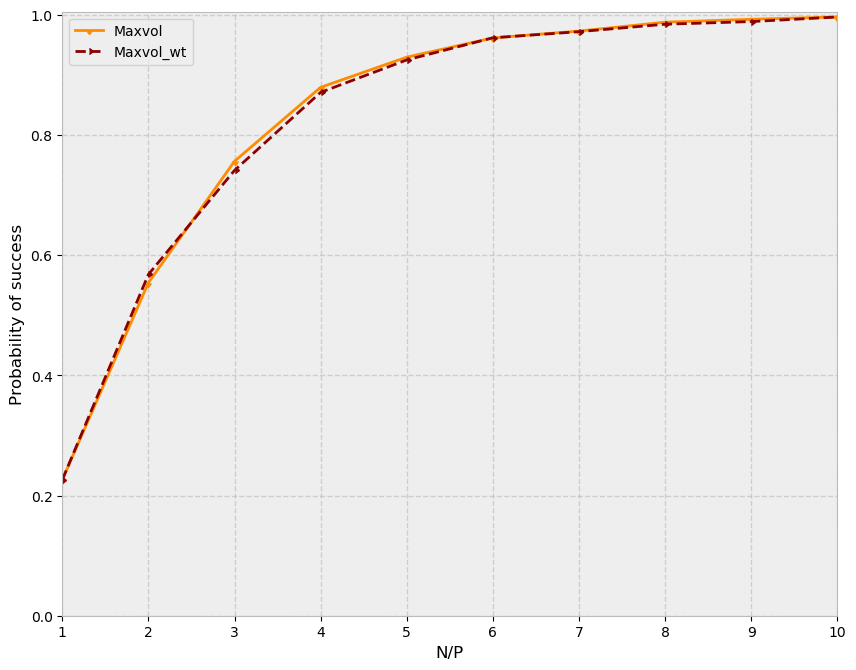

In [21]:
# Nc_N_ratio = 1000
plt.figure(figsize=(10,8), dpi=100)

plt.plot(N_div_P, errors, 'darkorange', marker=11, label='Maxvol')
plt.plot(N_div_P, errors_wt, 'darkred', marker=9, label='Maxvol_wt')
plt.xlabel('N/P')
plt.ylabel('Probability of success')
plt.xlim(1,10)
plt.ylim(0,1.005)
plt.legend()
plt.show()

In [9]:
# pymc4

#@pm.model
#def model():
    #x = yield pm.Normal('x', loc=0, scale=1)
    #x = yield pm.DensityDist('x',
    #                         lambda y: np.exp(-y**2) )
    #x = yield pm.Potential(lambda y: np.exp(-y**2))
    #pass

    
    
#trace = pm.sample(model(), num_samples=10000, num_chains=3)

In [123]:
# pymc3

model = pm.Model()

def f1(x):
    #return -(y-2)**2/2 + np.polynomial.legendre.legval(x, [0,0,1])
    #return -(y-2)**2/2 + np.exp(y)
    return (-(x-2)**2/2 + np.polynomial.legendre.legval(x, [0,0,1])**2)*\
        ((np.arctan((x+1)*1e5)/(np.pi/2) + 1)/2 + (np.arctan((1-x)*1e5)/(np.pi/2) + 1)/2)/2
    

def f2(x):
    b11 = 1
    b22 = 1
    b12 = 0.4
    print (x)
    #return -x**2/2
    return b11*x[0]**2 + b22*x[1]**2 + 2*b12*x[0]*x[1]
    
    
with model:
    dist = pm.Uniform.dist(-1, 1, shape=2)
    #x = pm.DensityDist('x', lambda y: -(y-2)**2/2)
    x = pm.DensityDist(
        'x',
        f2,
        shape=2,
        random=dist.random )


x
x
x


In [131]:
with model:
    trace = pm.sample(500, chains=6, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [x]
Sampling 6 chains, 0 divergences:  36%|███▌      | 3257/9000 [00:01<00:01, 3148.02draws/s]


RuntimeError: Chain 2 failed.

In [ ]:
az.plot_posterior(trace)